In [5]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for file in os.listdir('data/ACDC/training_normalized/masks'):
    img = np.load(os.path.join('data/ACDC/training_normalized/masks',  file), allow_pickle=True)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if img[i][j]!=0:
                img[i][j] = 255
            else:
                img[i][j] = 0
#     print(np.unique(img))
    img = img.astype(np.uint8)
    im = Image.fromarray(img)
#     im = im.convert("L")
    im.save(os.path.join('data/ACDC/train/mask', file.split('.')[0]+".jpg"))
    
    
    
    img1 = np.load(os.path.join('data/ACDC/training_normalized/images',  file), allow_pickle=True)
    
    im = Image.fromarray(img1)
    im.save(os.path.join('data/ACDC/train/images', file.split('.')[0]+".jpg"))

In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for file in os.listdir('data/ACDC/testing_normalized/masks'):
    img = np.load(os.path.join('data/ACDC/testing_normalized/masks',  file), allow_pickle=True)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if img[i][j]!=0:
                img[i][j] = 255
            else:
                img[i][j] = 0
#     print(np.unique(img))
    img = img.astype(np.uint8)
    im = Image.fromarray(img)
#     im = im.convert("L")
    im.save(os.path.join('data/ACDC/test/mask', file.split('.')[0]+".jpg"))
    
    
    
    img1 = np.load(os.path.join('data/ACDC/testing_normalized/images',  file), allow_pickle=True)
    
    im = Image.fromarray(img1)
    im.save(os.path.join('data/ACDC/test/images', file.split('.')[0]+".jpg"))

In [31]:
import os
import numpy as np
from skimage.measure import label, regionprops
import cv2

class Data:
    """
    Present images/masks to model.
    """
    def __init__(self, dataset_id, normalized_path_images, normalized_path_masks, image_size):
        self.dataset_id = dataset_id
        self.normalized_path_images = normalized_path_images
        self.normalized_path_masks = normalized_path_masks
        self.image_size = image_size

    def join_data(self):
        input_img_paths = sorted(
            [
                os.path.join(self.normalized_path_images, file)
                for file in os.listdir(self.normalized_path_images)
            ]
        )
        target_img_paths = sorted(
            [
                os.path.join(self.normalized_path_masks, file)
                for file in os.listdir(self.normalized_path_masks)
            ]
        )
        batch_size = len(input_img_paths)

        return input_img_paths, target_img_paths, batch_size

    def __getitem__(self, idx):
        input_img_paths, target_img_paths, batch_size = self.join_data()
        i = idx * batch_size
        batch_input = input_img_paths[i: i + batch_size]
        batch_target = target_img_paths[i: i + batch_size]
        x = np.zeros((batch_size,) + self.image_size, dtype="float32")
        names_images = []
        for j, path in enumerate(batch_input):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = img/255.0
            names_images.append(path.split('/')[-1])
            x[j] = img
        y = np.zeros((batch_size,) + self.image_size, dtype="float32")
        y_rect = np.zeros((batch_size,) + self.image_size, dtype="float32")
        names_masks = []
        for j, path in enumerate(batch_target):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = img/255.0
            where = np.array(np.where(img))

            x1, y1 = np.amin(where, axis=1)
            x2, y2 = np.amax(where, axis=1)
            mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8) # initialize mask
            mask[x1:(x2+1), y1:(y2+1)] = 1 # fill with white pixels
            names_masks.append(path.split('/')[-1])
            y[j] = img
            y_rect[j] = mask
        return x, y,y_rect, names_images, names_masks

In [32]:
DATA_ROOT = 'data'

ACDC = {
    'id': 0,
    'image_size': (192, 192),
    'raw_path': DATA_ROOT + '/ACDC/database/training',
    'training_set': {
        'path': DATA_ROOT + '/ACDC/train',
        'path_normalized': DATA_ROOT + '/ACDC/train',
        'path_normalized_images': DATA_ROOT + '/ACDC/train' + '/images',
        'path_normalized_masks': DATA_ROOT + '/ACDC/train' + '/mask'
    },
    'testing_set': {
        'path': DATA_ROOT + '/ACDC/test',
        'path_normalized': DATA_ROOT + '/ACDC/test',
        'path_normalized_images': DATA_ROOT + '/ACDC/test' + '/images',
        'path_normalized_masks': DATA_ROOT + '/ACDC/test' + '/mask'
    }
}

In [33]:
training_set = Data(
        ACDC['id'],
        ACDC['training_set']['path_normalized_images'],
        ACDC['training_set']['path_normalized_masks'],
        ACDC['image_size']
    )[0]

In [34]:
import matplotlib.pyplot as plt

In [36]:
training_set[0][100]

array([[0.01960784, 0.01960784, 0.01568628, ..., 0.27450982, 0.25490198,
        0.23529412],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.25490198, 0.25490198,
        0.24705882],
       [0.00392157, 0.00784314, 0.00784314, ..., 0.23529412, 0.24705882,
        0.25490198],
       ...,
       [0.18039216, 0.30588236, 0.5058824 , ..., 0.25490198, 0.43529412,
        0.47843137],
       [0.21176471, 0.22745098, 0.3882353 , ..., 0.22352941, 0.44313726,
        0.48235294],
       [0.23137255, 0.16078432, 0.26666668, ..., 0.19607843, 0.4392157 ,
        0.4745098 ]], dtype=float32)

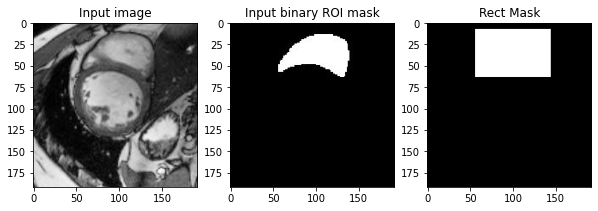

In [37]:
f, ax = plt.subplots(ncols = 3, figsize=(10,10))
ax[0].imshow(training_set[0][100].reshape(192,192), cmap = "gray")
ax[0].set_title('Input image')
ax[1].imshow(training_set[1][100].reshape(192, 192), cmap = "gray")
_ = ax[1].set_title('Input binary ROI mask')
ax[2].imshow(training_set[2][100].reshape(192,192), cmap = "gray")
_ = ax[2].set_title('Rect Mask')

In [38]:
testing_set = Data(
        ACDC['id'],
        ACDC['testing_set']['path_normalized_images'],
        ACDC['testing_set']['path_normalized_masks'],
        ACDC['image_size']
    )[0]

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [40]:
class Classification(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 11, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 11, stride = 1, padding = 1),
            nn.ReLU(),
            nn.AvgPool2d(6,6),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(12544,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,192*192)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [41]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [52]:
def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(outputs == labels).item() / len(outputs))

def validation_step(batch):
        images, labels = batch
        images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2])
        labels = labels.reshape(labels.shape[0], labels.shape[1] * labels.shape[2])
        images, labels= images.to(device), labels.to(device)
        out = model(images)                  # Generate predictions

        loss = F.mse_loss(out, labels)   # Calculate loss
        return {'val_loss': loss.detach()}
        
def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    return {'val_loss': epoch_loss.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss']))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(batch) for batch in val_loader]
    
    return validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    early_stopper = EarlyStopper(patience=10, min_delta=0.0002)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            
            images, labels = batch
#             print(images.shape)
            images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2])
            labels = labels.reshape(labels.shape[0], labels.shape[1] * labels.shape[2])
            images, labels= images.to(device), labels.to(device)
            out = model(images)                  # Generate predictions
            
#             print(out.shape)
#             print(labels.shape)
            
            loss = criterion(out,labels)
            train_losses.append(loss)
            loss.backward()
            opt_func.step()
            opt_func.zero_grad()
            
        result = evaluate(model, val_loader)
        if early_stopper.early_stop(result['val_loss']):
            print("Early Stopping")
            break
        result['train_loss'] = torch.stack(train_losses).mean().item()
        epoch_end(epoch, result)
        history.append(result)
        wandb.log({
        "Epoch": epoch,
        "Train Loss": result['train_loss'],
        "Valid Loss": result['val_loss']})
    
    return history


In [53]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.img_labels = dataset[2]
        self.img_dir = dataset[0]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_dir[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [54]:
train_data = CustomImageDataset(training_set)

In [55]:
test_data = CustomImageDataset(testing_set)

In [56]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(test_data, batch_size*2, num_workers = 4, pin_memory = True)

In [57]:
model = nn.DataParallel(Classification())

In [58]:
if torch.cuda.is_available():
    print('t')
    model.cuda()

t


In [50]:
import wandb

wandb.init(name='CNN', 
           project='MIA',
           notes='ROI Localization', 
           tags=['ACDC dataset', 'Train Run'])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sashank-ssridhar. Use `wandb login --relogin` to force relogin


In [59]:
num_epochs = 3000
opt_func = torch.optim.Adam(model.parameters(),lr = 1e-5,eps=1e-8, betas=[0.9,0.999])
lr = 0.001

criterion = nn.MSELoss()
criterion.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.1148, val_loss: 0.1216
Epoch [1], train_loss: 0.1141, val_loss: 0.1215
Epoch [2], train_loss: 0.1134, val_loss: 0.1212
Epoch [3], train_loss: 0.1135, val_loss: 0.1205
Epoch [4], train_loss: 0.1124, val_loss: 0.1196
Epoch [5], train_loss: 0.1118, val_loss: 0.1183
Epoch [6], train_loss: 0.1104, val_loss: 0.1166
Epoch [7], train_loss: 0.1088, val_loss: 0.1144
Epoch [8], train_loss: 0.1065, val_loss: 0.1117
Epoch [9], train_loss: 0.1039, val_loss: 0.1085
Epoch [10], train_loss: 0.1006, val_loss: 0.1050
Epoch [11], train_loss: 0.0968, val_loss: 0.1013
Epoch [12], train_loss: 0.0929, val_loss: 0.0977
Epoch [13], train_loss: 0.0893, val_loss: 0.0942
Epoch [14], train_loss: 0.0857, val_loss: 0.0906
Epoch [15], train_loss: 0.0823, val_loss: 0.0875
Epoch [16], train_loss: 0.0794, val_loss: 0.0847
Epoch [17], train_loss: 0.0767, val_loss: 0.0823
Epoch [18], train_loss: 0.0744, val_loss: 0.0802
Epoch [19], train_loss: 0.0724, val_loss: 0.0783
Epoch [20], train_loss: 0.0706

In [60]:
history

[{'val_loss': 0.12164636701345444, 'train_loss': 0.11479765176773071},
 {'val_loss': 0.12146201729774475, 'train_loss': 0.11408132314682007},
 {'val_loss': 0.12115149945020676, 'train_loss': 0.11339471489191055},
 {'val_loss': 0.12049129605293274, 'train_loss': 0.11352813243865967},
 {'val_loss': 0.11955271661281586, 'train_loss': 0.11240022629499435},
 {'val_loss': 0.1182752251625061, 'train_loss': 0.11181622743606567},
 {'val_loss': 0.1165805384516716, 'train_loss': 0.11043731123209},
 {'val_loss': 0.11437961459159851, 'train_loss': 0.10879510641098022},
 {'val_loss': 0.11170641332864761, 'train_loss': 0.10653416067361832},
 {'val_loss': 0.10851472616195679, 'train_loss': 0.10387744009494781},
 {'val_loss': 0.10495004057884216, 'train_loss': 0.10058090835809708},
 {'val_loss': 0.10132433474063873, 'train_loss': 0.0968417152762413},
 {'val_loss': 0.0977029800415039, 'train_loss': 0.09291847795248032},
 {'val_loss': 0.09422560036182404, 'train_loss': 0.0892992839217186},
 {'val_loss': 

Text(0, 0.5, 'Loss')

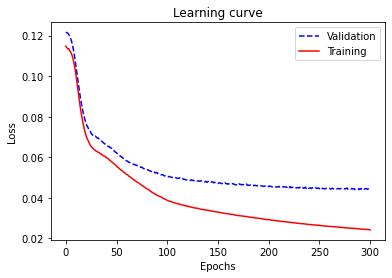

In [61]:
t_loss = [h['train_loss'] for h in history ]
v_loss = [h['val_loss'] for h in history ]

fig, ax = plt.subplots()
ax.plot(range(len(history)), v_loss, '--b', label='Validation')
ax.plot(range(len(history)), t_loss, '-r', label='Training')
leg = ax.legend()
plt.title("Learning curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [62]:
result = evaluate(model, val_dl)

In [63]:
torch.save(model.state_dict(), './model/cnn.pth')

In [64]:
model.load_state_dict(torch.load('./model/cnn.pth'))

<All keys matched successfully>

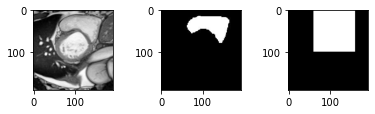

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


images, labels = testing_set[0][0], testing_set[1][0]

images = images.reshape((1, 1, 192, 192))
images, labels= torch.from_numpy(images), torch.from_numpy(labels)
out = model(images)                  # Generate predictions

out = out.cpu().detach().numpy()
out[0] = np.uint8(out[0])
where = np.array(np.where(out[0].reshape(192, 192)))

x1, y1 = np.amin(where, axis=1)
x2, y2 = np.amax(where, axis=1)
X_middle = x1 + (x2 - x1) / 2
Y_middle = y1 + (y2 - y1) / 2
# Find ROI coordinates
X_top = int(X_middle - 50)
Y_top = int(Y_middle - 50)
X_down = int(X_middle + 50 )
Y_down = int(Y_middle + 50 )

if X_top <= 0:
    X_down = X_down + (100 - (X_down - X_top)) - X_top
    X_top = 0

if Y_top <= 0:
    Y_down = Y_down + (100 - (Y_down - Y_top)) - Y_top
    Y_top = 0

if X_down > 191:
    X_top = X_top + (191 - X_down)
    X_down = 191

if Y_down > 191:
    Y_top = Y_top + (191- Y_down)
    Y_down = 191
mask = np.zeros((out[0].reshape(192, 192).shape[0],out[0].reshape(192, 192).shape[1]),dtype=np.uint8) # initialize mask
mask[X_top:X_down, Y_top:Y_down] = 255 # fill with white pixels

fig = plt.figure()
fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
fig.suptitle('', fontsize = 15)
fig.subplots_adjust(top = 1.15)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(images[0].cpu().numpy().reshape((192, 192)), cmap = "gray")
#     ax.title.set_text.suptitle('Image')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(labels, cmap = "gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(mask, cmap = "gray")
#     setTitleAndRemoveTicks(ax, 'Original\nMask')


